# ☀️ Time Series Analysis & Temperature Forecasting with Weather data ☀️


## Motivation / Problem Statement

For some time, I have been interested in learning about time series and analyzing historical weather data to identify long-term patterns. With the increasing occurrence of uncommon weather events in different regions, it has become even more important to understand how the temperature is changing over time. Have temperature variations, whether colder or hotter, influenced weather patterns over time?

### Weather Data Sources

I selected these datasets because of my interest in climate data and desire to explore the intricacies of time series analysis. By leveraging these datasets, I hope to identify meaningful trends and gain an understanding of the complex factors that influence the planet's climate. For a future extension, I will incorporate both datasets below and/or find additional datasets to enrich the dataset to review temperature and weather events together.

[The Weather Dataset](https://www.kaggle.com/datasets/guillemservera/global-daily-climate-data?select=cities.csv) - 3 files

[US Weather Events (2016 - 2022)](https://www.kaggle.com/datasets/sobhanmoosavi/us-weather-events) - 1 file



#### Adding Kaggle Datasets to Kaggle notebooks

Under the Data section add dataset/s to use for your analysis

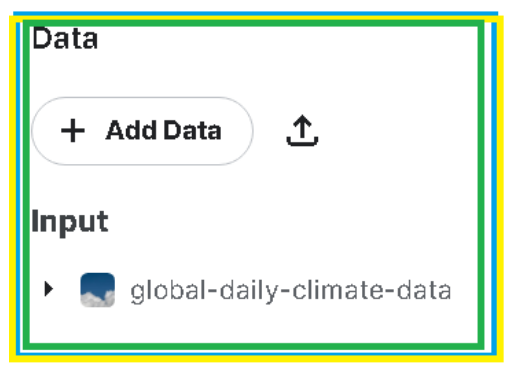



## Import Modules - Dependencies

Warnings are suppressed, but if the Python libraries are not installed an error will be generated - run the command below to install
    
<code>!pip install library_name<\code>   

In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot

import seaborn as sns
sns.set(color_codes=True)
import seaborn.objects as so

import matplotlib.pyplot as plt
%matplotlib inline

from dateutil.parser import parse

import gc

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
from scipy import signal

from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

In [3]:
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda, Reshape, RNN, LSTMCell

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

### Read Files 
 Retrieve data and load into dataframe 

 [The Weather Dataset](https://www.kaggle.com/datasets/guillemservera/global-daily-climate-data?select=cities.csv) 
 
---<b><u>cities data</b></u>---

station_id | city_name | country | state | iso2 | iso3 | latitude | longitude  

---<b><u>global weather data</b></u>---

station_id | city_name | date | season | avg_temp_c	| min_temp_c | max_temp_c | precipitation_mm | snow_depth_mm |

avg_wind_dir_deg | avg_wind_speed_kmh | peak_wind_gust_kmh | avg_sea_level_pres_hpa | sunshine_total_min

In [4]:
# dataset 1 - CSV
gbl_cities_data = pd.read_csv('/kaggle/input/global-daily-climate-data/cities.csv')

# dataset 1 - parquet file
gbl_weather_data = pd.read_parquet('/kaggle/input/global-daily-climate-data/daily_weather.parquet')

# Explore and Transform


In [55]:
# display data
print(f"\n---cities data---\n")  
gbl_cities_data.sample(3)          # display random 3 rows to view data


---cities data---



,station_id,city_name,country,state,iso2,iso3,latitude,longitude
542,35700,Atyrau,Kazakhstan,Atyrau,KZ,KAZ,47.112691,51.920024
733,47058,Pyongyang,North Korea,P'yongyang,KP,PRK,39.019439,125.754691
373,07020,St. Peter Port,Guernsey,Unknown,GG,GGY,49.456814,-2.538998


## Drop columns (global) cities dataframes

In [5]:
# Drop columns not needed at this time
gbl_cities_data.drop(["iso2", "iso3"], axis=1, inplace=True)

gbl_cities_data.columns

Index(['station_id', 'city_name', 'country', 'state', 'latitude', 'longitude'], dtype='object')

## Rename Countries

Review countries data to make sure the countries are consistent in names are consistent and same amount of countries are represented in both datasets.This is in preparation for merging the cities dataframe (doesn't include countries) and global weather data (only includes countries). 

In [57]:
# check unique countries in cities dataframe
print(f"Number of countries: {gbl_cities_data['country'].nunique()}")
print(f"Country names: {gbl_cities_data['country'].unique()}")

Number of countries: 216
Country names: ['Afghanistan' 'Albania' 'Algeria' 'American Samoa' 'Andorra' 'Angola'
 'Anguilla' 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Aruba'
 'Australia' 'Austria' 'Azerbaijan' 'Bahrain' 'Bangladesh' 'Belarus'
 'Belgium' 'Belize' 'Benin' 'Bermuda' 'Bhutan' 'Bolivia'
 'Bosnia and Herzegovina' 'Botswana' 'Brazil' 'Brunei' 'Bulgaria'
 'Burkina Faso' 'Burundi' 'Cambodia' 'Cameroon' 'Canada' 'Cape Verde'
 'Cayman Islands' 'Central African Republic' 'Chad' 'Chile' 'China'
 'Christmas Island' 'Colombia' 'Comoros' 'Congo (Brazzaville)'
 'Congo (Kinshasa)' 'Cook Islands' 'Costa Rica' 'Croatia' 'Cuba' 'Cyprus'
 'Czech Republic' 'Denmark' 'Djibouti' 'Dominica' 'Dominican Republic'
 'East Timor' 'Ecuador' 'Egypt' 'El Salvador' 'Equatorial Guinea'
 'Estonia' 'Ethiopia' 'Falkland Islands' 'Fiji' 'Finland' 'France'
 'French Guiana' 'French Polynesia' 'French Southern and Antarctic Lands'
 'Gabon' 'Georgia' 'Germany' 'Ghana' 'Gibraltar' 'Greece' 'Greenland'
 'Grenada'

In [6]:
# Rename countries in cities dataframe to be consistent with countries dataframe
gbl_cities_data = gbl_cities_data.replace(['United States of America', 'Guinea Bissau', 'Svalbard and Jan Mayen Islands', 'Congo (Kinshasa)', 'Macau S.A.R', 'Congo (Brazzaville)'],['United States','Guinea-Bissau','Svalbard and Jan Mayen','Democratic Republic of the Congo','Macau','Republic of the Congo'])

### Filter out countries and states
 Filter the dataframes so the country columns match when merged

In [7]:
# Filter out from gbl_cities_data - countries not included in other dataset
values = ['Andorra', 'Montenegro', 'Myanmar', 'Unknown']
gbl_cities_data = gbl_cities_data[gbl_cities_data.country.isin(values) == False]

In [8]:
# Filter out states that are Unknown and Hawaii since not included in the US event dataset
values = ['Hawaii', 'Unknown']
gbl_cities_data = gbl_cities_data[gbl_cities_data.state.isin(values) == False]

In [9]:
# Filter out District of Columbia since they are not included in the US event dataset
values = ['District of Columbia', 'Unknown']
gbl_cities_data = gbl_cities_data[gbl_cities_data.city_name.isin(values) == False]

In [10]:
# Drop columns not needed at this time
gbl_cities_data.drop(["city_name", "state"], axis=1, inplace=True)

gbl_cities_data.columns

Index(['station_id', 'country', 'latitude', 'longitude'], dtype='object')

### Global Weather


## Histogram Global Weather Data - Date Distribution

<Axes: >

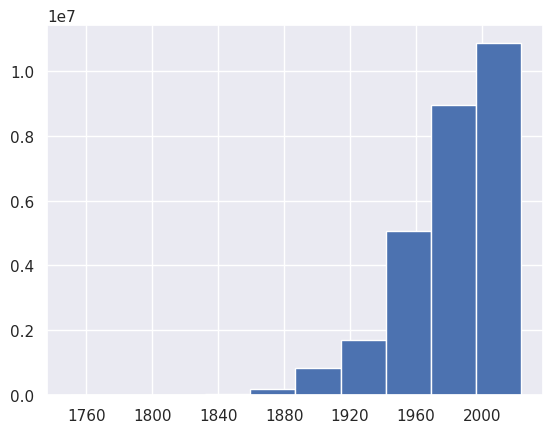

In [13]:
# display histograms
gbl_weather_data['date'].hist()

## Filter Weather data

Based on the histogram above narrow down the timeframe for the date column to decrease amount of rows read and speed things up.

#### Display date column, shape and min\max values

In [12]:
# display timeframe of the weather data
gbl_weather_data['date']

0       1957-07-01
1       1957-07-02
2       1957-07-03
3       1957-07-04
4       1957-07-05
           ...    
24216   2023-09-01
24217   2023-09-02
24218   2023-09-03
24219   2023-09-04
24220   2023-09-05
Name: date, Length: 27635763, dtype: datetime64[ns]

In [13]:
# calculating Min and Max DateTimes to review timeframe range
print(f"min date: {gbl_weather_data['date'].min()}")
print(f"max date: {gbl_weather_data['date'].max()}")

min date: 1750-02-01 00:00:00
max date: 2023-09-05 00:00:00


#### Filter Global Weather By Date

From the histogram it seems more of the data was captured after 1960's (70's and 80's). Randomly selected an 80's - 1982 as a start date and 12-31-2022 as an end date (for full yearly data capture) and to lessen the amount rows in the dataframe.

In [11]:
# Drop columns not needed at this time
gbl_weather_data.drop(["city_name"], axis=1, inplace=True)

In [12]:
# Filter dates following a date range from histogram 
gweather_subset_date = \
   gbl_weather_data[(gbl_weather_data['date'] >= '1982-01-01 00:00:00') & (gbl_weather_data['date'] < '2023-01-01 00:00:00')]

In [67]:
# display rows and columns after filter
gweather_subset_date.shape

(15641531, 13)

##  Merge dataframes - Global Cities and Global Weather data 

Merged the datasets in order to connect the cities data with the weather data and perform the time series analysis. Before merging review datatypes, columns, and shape.

In [13]:
# display data types
print(gweather_subset_date.isnull().sum())
print(f"\n{gbl_cities_data.isnull().sum()}")

station_id                       0
date                             0
season                           0
avg_temp_c                  719972
min_temp_c                 2883808
max_temp_c                 2481795
precipitation_mm           4849446
snow_depth_mm             13674550
avg_wind_dir_deg          12922471
avg_wind_speed_kmh        11295169
peak_wind_gust_kmh        14901403
avg_sea_level_pres_hpa    12586414
sunshine_total_min        15074844
dtype: int64

station_id    0
country       0
latitude      0
longitude     0
dtype: int64


In [20]:
print(gweather_subset_date.dtypes)
print(f"\n{gbl_cities_data.dtypes}")

station_id                      category
date                      datetime64[ns]
season                          category
avg_temp_c                       float64
min_temp_c                       float64
max_temp_c                       float64
precipitation_mm                 float64
snow_depth_mm                    float64
avg_wind_dir_deg                 float64
avg_wind_speed_kmh               float64
peak_wind_gust_kmh               float64
avg_sea_level_pres_hpa           float64
sunshine_total_min               float64
dtype: object

station_id     object
country        object
latitude      float64
longitude     float64
dtype: object


## Merge dataframes to a new cities_weather dataframe

Merge the datasets on station_id since both datasets have that column in common. 

Merging in order to analyze the global weather data - global weather data does not include the country data which is needed to observe country weather changes over the years.

In [14]:
# Merge dataframe
cities_weather = pd.merge(gweather_subset_date, gbl_cities_data,left_on='station_id',right_on='station_id',how='inner')

In [15]:
del gbl_cities_data, gbl_weather_data, gweather_subset_date
gc.collect()

53

In [16]:
# Drop station_id only needed to merge dataframes 
cities_weather.drop(["station_id"], axis=1, inplace=True)

### Drop rows with NaNs for the specified columns

Filter out Unknown values for states and drop NaN values

### Drop NaNs

In [17]:
# Drop rows with NaN values in specific columns
cities_weather.dropna(subset=['avg_temp_c','min_temp_c','max_temp_c','precipitation_mm','snow_depth_mm',\
                                          'avg_wind_dir_deg','avg_wind_speed_kmh','peak_wind_gust_kmh',\
                                          'avg_sea_level_pres_hpa','sunshine_total_min'],inplace=True)

In [18]:
#cities_weather
cities_weather.shape

(281206, 15)

In [19]:
# display columns with null values - duplicated columns will be dropped in another cell
print("\n---Weather data---")
print(cities_weather.isnull().sum())


---Weather data---
date                      0
season                    0
avg_temp_c                0
min_temp_c                0
max_temp_c                0
precipitation_mm          0
snow_depth_mm             0
avg_wind_dir_deg          0
avg_wind_speed_kmh        0
peak_wind_gust_kmh        0
avg_sea_level_pres_hpa    0
sunshine_total_min        0
country                   0
latitude                  0
longitude                 0
dtype: int64


In [74]:
print("\nMININUM\n")
print(f"Avg Temperature Min value: {cities_weather['avg_temp_c'].min()}")
print(f"Max Temperature Min value: {cities_weather['max_temp_c'].min()}")
print(f"Max Temperature Min value: {cities_weather['min_temp_c'].min()}")
print("\nMAXINUM\n")
print(f"Avg Temperature Max value: {cities_weather['avg_temp_c'].max()}")
print(f"Max Temperature Max value: {cities_weather['max_temp_c'].max()}")
print(f"Max Temperature Max value: {cities_weather['min_temp_c'].max()}")


MININUM

Avg Temperature Min value: -32.2
Max Temperature Min value: -30.6
Max Temperature Min value: -35.0

MAXINUM

Avg Temperature Max value: 40.1
Max Temperature Max value: 47.8
Max Temperature Max value: 33.9


In [21]:
# calculating Min and Max DateTimes to review timeframe range
print(f"min date: {cities_weather['date'].min()}")
print(f"max date: {cities_weather['date'].max()}")

min date: 1982-01-01 00:00:00
max date: 2022-12-31 00:00:00


### Visualize average/max/min temperature and Clip outliers

Based on boxplots - remove extreme outliers and visualize updated data

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'American Samoa'),
  Text(1, 0, 'Denmark'),
  Text(2, 0, 'Germany'),
  Text(3, 0, 'Guam'),
  Text(4, 0, 'Sweden'),
  Text(5, 0, 'Switzerland'),
  Text(6, 0, 'United States')])

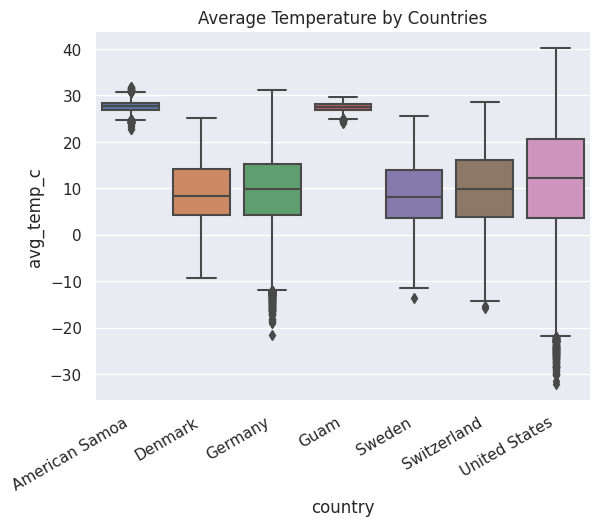

In [22]:
# boxplot countries - average temperature
sns.boxplot(data=cities_weather, x ='country', y ='avg_temp_c').set_title('Average Temperature by Countries')
plt.xticks(rotation=30, ha='right')

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'American Samoa'),
  Text(1, 0, 'Denmark'),
  Text(2, 0, 'Germany'),
  Text(3, 0, 'Guam'),
  Text(4, 0, 'Sweden'),
  Text(5, 0, 'Switzerland'),
  Text(6, 0, 'United States')])

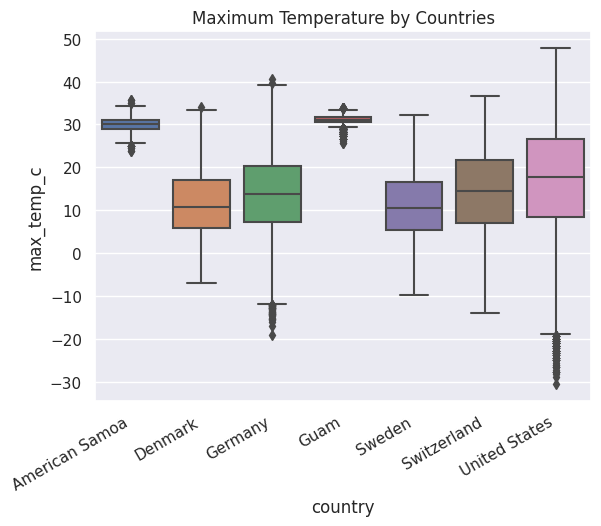

In [20]:
# boxplot countries - max temperature
sns.boxplot(data=cities_weather, x ='country', y ='max_temp_c').set_title('Maximum Temperature by Countries')
plt.xticks(rotation=30, ha='right')

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'American Samoa'),
  Text(1, 0, 'Denmark'),
  Text(2, 0, 'Germany'),
  Text(3, 0, 'Guam'),
  Text(4, 0, 'Sweden'),
  Text(5, 0, 'Switzerland'),
  Text(6, 0, 'United States')])

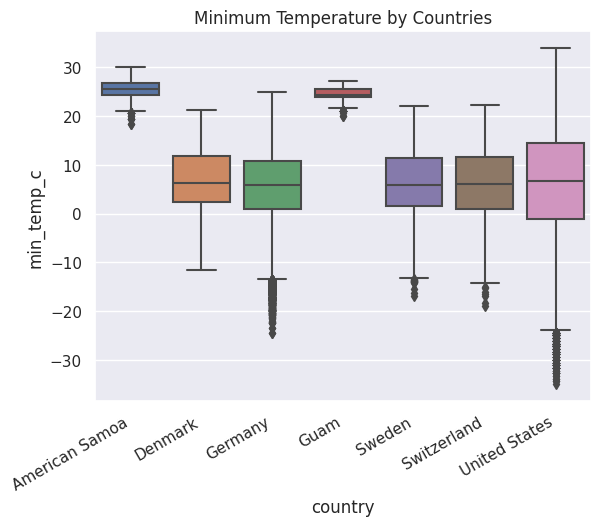

In [21]:
# boxplot countries - min temperature
sns.boxplot(data=cities_weather, x ='country', y ='min_temp_c').set_title('Minimum Temperature by Countries')
plt.xticks(rotation=30, ha='right')

### Clip outliers

Based on visuals above - decided to remove extreme outliers and visualize updated data

In [20]:
# Remove outliers shown on boxplots for Average Temperature
upper_threshold = 30
lower_threshold = 5

cities_weather['avg_temp_c'][(cities_weather['avg_temp_c'] > upper_threshold) | (cities_weather['avg_temp_c'] < lower_threshold)]

# Clip values to the specified bounds
cities_weather['avg_temp_c'] = cities_weather['avg_temp_c'].clip(lower=lower_threshold, upper=upper_threshold)

In [21]:
# Remove outliers shown on boxplots for Maximum Temperature
upper_threshold = 32
lower_threshold = 5

cities_weather['max_temp_c'][(cities_weather['max_temp_c'] > upper_threshold) | (cities_weather['max_temp_c'] < lower_threshold)]

# Clip values to the specified bounds
cities_weather['max_temp_c'] = cities_weather['max_temp_c'].clip(lower=lower_threshold, upper=upper_threshold)

In [23]:
# Remove outliers shown on boxplots for Minimum Temperature
upper_threshold = 25
lower_threshold = -2.5

cities_weather['min_temp_c'][(cities_weather['min_temp_c'] > upper_threshold) | (cities_weather['min_temp_c'] < lower_threshold)]

# Clip values to the specified bounds
cities_weather['min_temp_c'] = cities_weather['min_temp_c'].clip(lower=lower_threshold, upper=upper_threshold)

### Sort date column
Going through the data - it seems the date column is not sorted

In [24]:
# sort
cities_weather = cities_weather.sort_values(by=['date'])

#### Reset Index

Based on the table above after sorting the date column the indexes are not in the correct order

In [25]:
cities_weather = cities_weather.reset_index(drop=True)
cities_weather

,date,season,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh,peak_wind_gust_kmh,avg_sea_level_pres_hpa,sunshine_total_min,country,latitude,longitude
0,1982-01-01,Summer,26.6,25.0,28.3,43.4,0.0,338.0,28.7,85.0,1008.6,30.0,American Samoa,-14.276610,-170.706645
1,1982-01-01,Winter,5.0,0.6,5.0,35.1,0.0,86.0,23.7,57.2,1014.0,0.0,United States,42.329960,-71.070014
2,1982-01-01,Winter,6.8,1.7,10.6,8.4,0.0,341.0,24.1,51.8,1012.4,162.0,United States,38.978330,-76.492499
3,1982-01-01,Winter,5.0,-0.3,5.0,2.0,0.0,270.0,10.8,39.6,1002.2,0.0,Germany,53.633304,11.416699
4,1982-01-01,Winter,5.0,4.0,8.2,5.7,20.0,159.0,9.4,33.5,1007.2,66.0,Germany,48.779980,9.199996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281201,2022-12-31,Winter,13.8,10.2,17.0,12.4,0.0,212.0,19.8,69.1,1005.3,0.0,Germany,52.366970,9.716657
281202,2022-12-31,Winter,9.9,8.0,12.1,6.4,0.0,213.0,19.8,45.4,1000.5,0.0,Denmark,55.432998,11.566702
281203,2022-12-31,Winter,9.9,7.2,12.4,6.3,0.0,222.0,38.2,68.0,1002.5,0.0,Sweden,55.583337,13.033302
281204,2022-12-31,Winter,14.1,7.8,17.3,0.0,0.0,215.0,26.3,68.4,1005.9,43.0,Germany,52.400405,13.069993


In [27]:
# calculating Min and Max DateTimes to review timeframe range
print(f"min date: {cities_weather['date'].min()}")
print(f"max date: {cities_weather['date'].max()}")

min date: 1982-01-01 00:00:00
max date: 2022-12-31 00:00:00


(array([0, 1, 2, 3]),
 [Text(0, 0, 'Autumn'),
  Text(1, 0, 'Spring'),
  Text(2, 0, 'Summer'),
  Text(3, 0, 'Winter')])

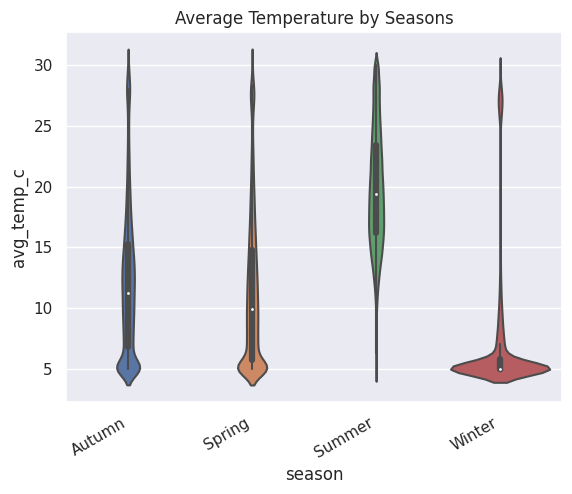

In [26]:
# violin plot seasons - average temperature
sns.violinplot(x ='season', y ='avg_temp_c', data=cities_weather).set_title('Average Temperature by Seasons')
plt.xticks(rotation=30, ha='right')

#### Scatter plots to review the different numerial features

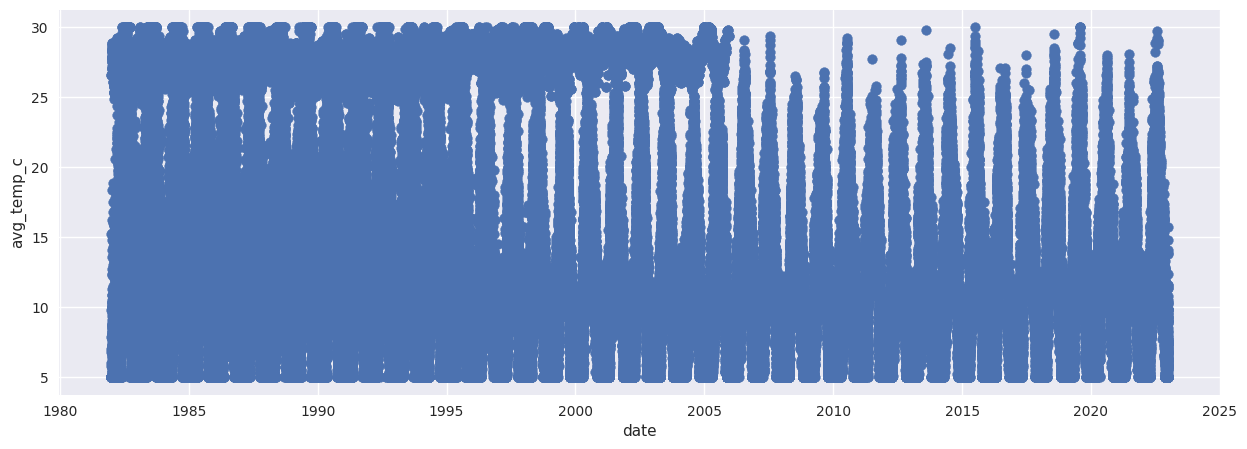

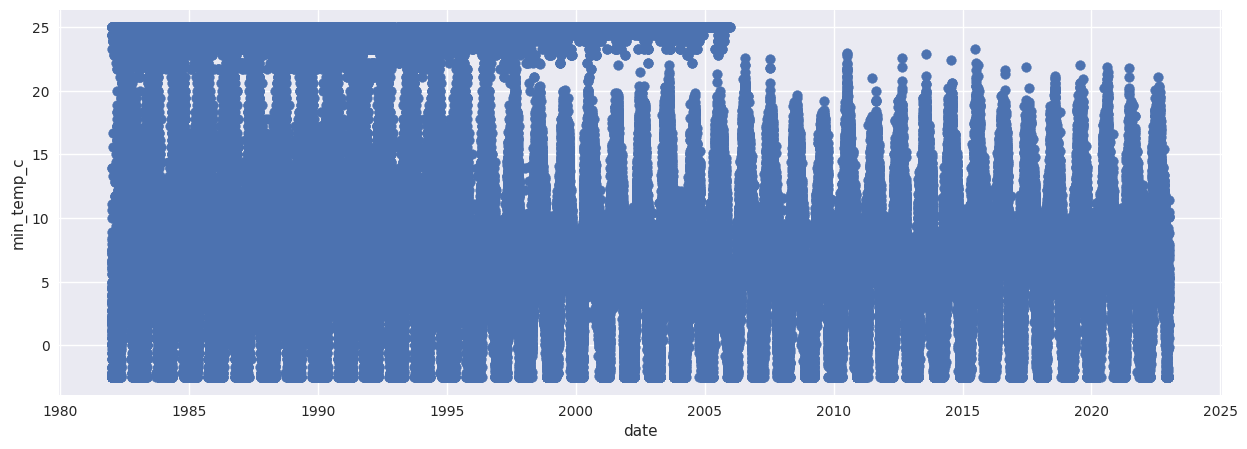

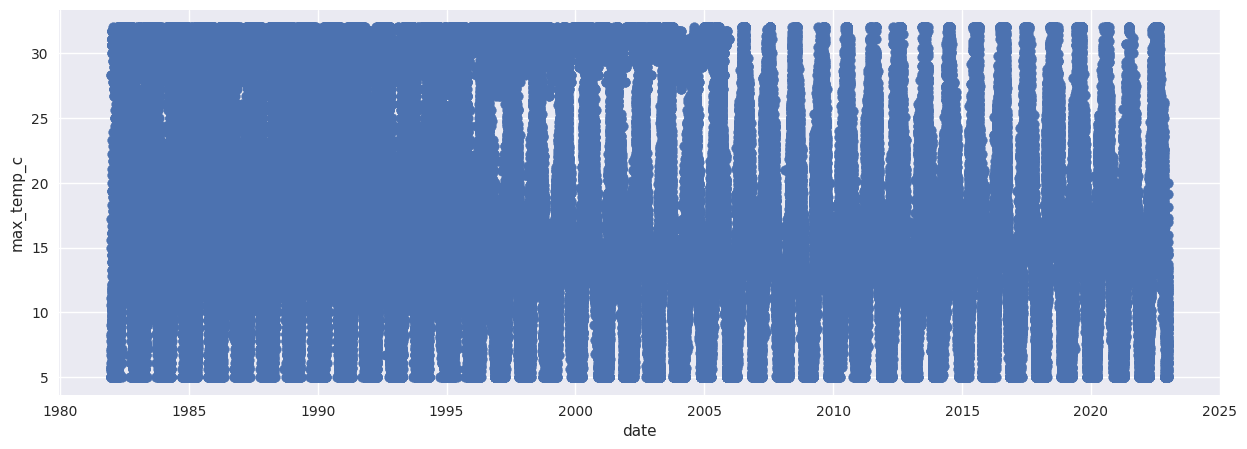

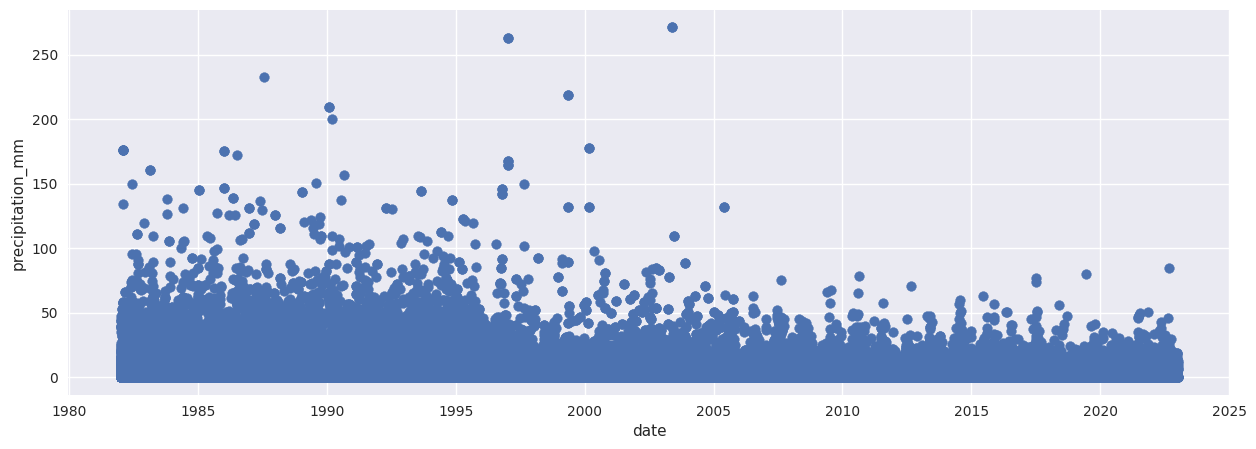

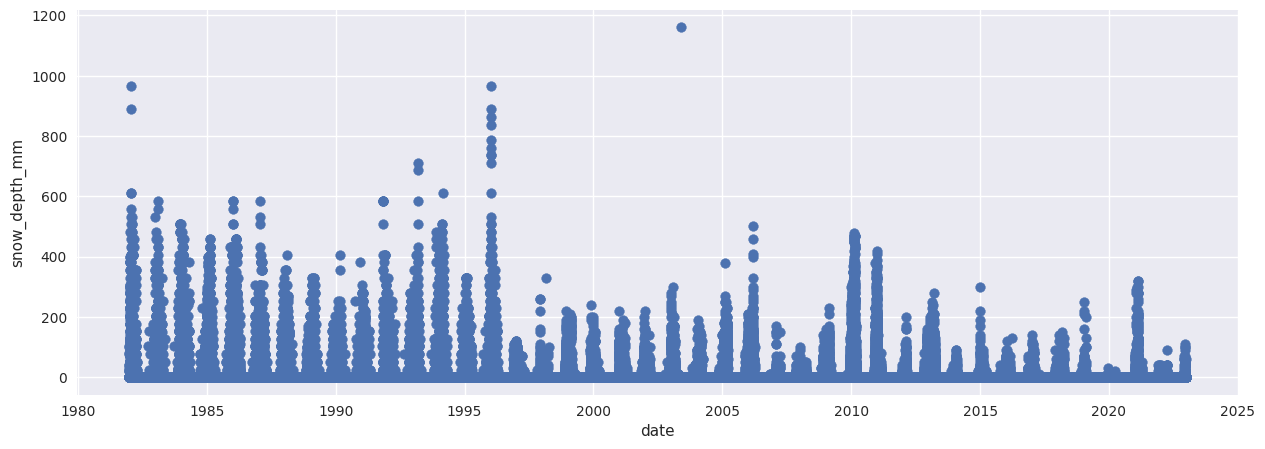

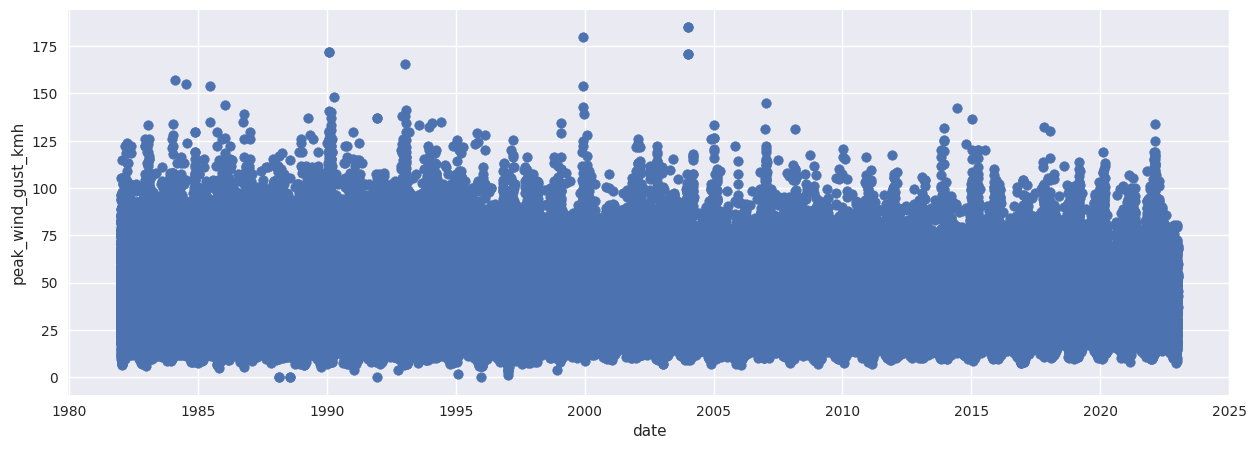

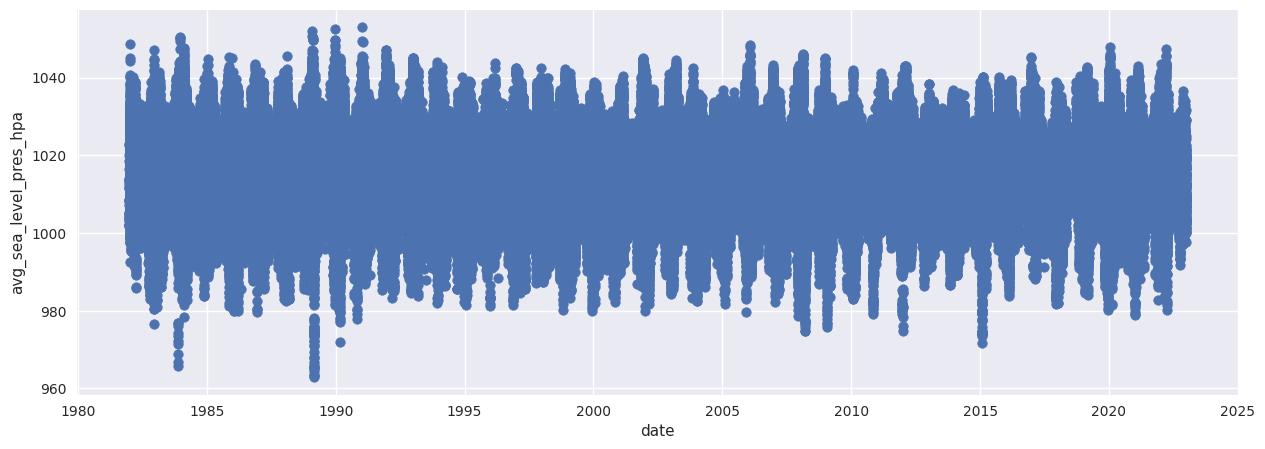

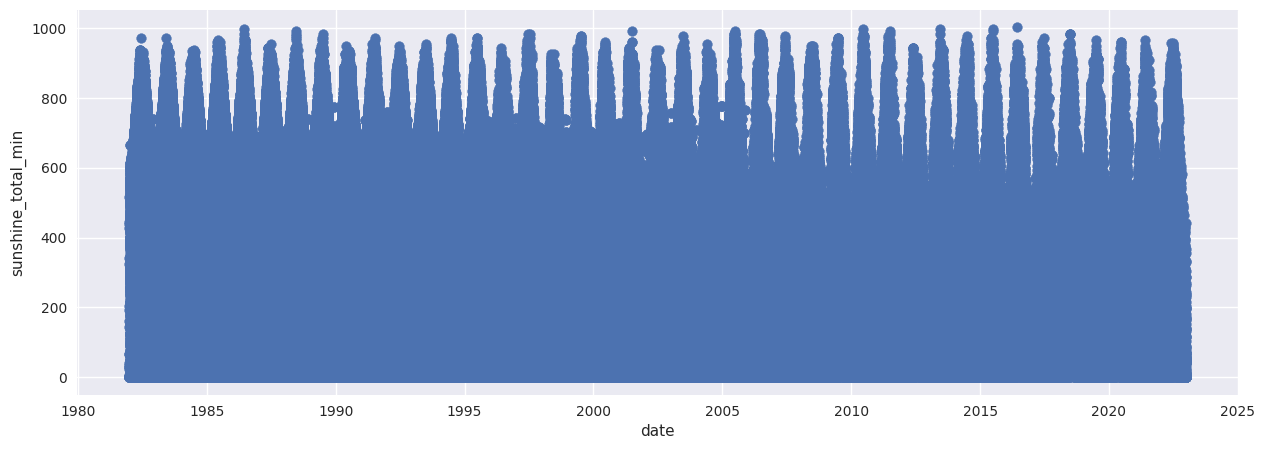

In [88]:
plt.style.use('seaborn')

wfeatures = ['avg_temp_c', 'min_temp_c', 'max_temp_c', 'precipitation_mm', 'snow_depth_mm', 
             'peak_wind_gust_kmh', 'avg_sea_level_pres_hpa', 'sunshine_total_min']

 # scatter plots
x = cities_weather['date']

for col in wfeatures:
      plt.figure(figsize=(15, 5))
      y = cities_weather[col]
      plt.scatter(x, y)
      plt.xlabel('date')
      plt.ylabel(col)
      plt.show()

#### Apply aggregate functions to the grouped data

In [89]:
# Grouping by 'contry' and 'season' and calculating statistics
grouped_data = cities_weather.groupby(['country', 'season'])

agg_results = grouped_data.avg_temp_c.agg(['mean', 'min', 'max'])
agg_results

mean   min   max
country        season                       
American Samoa Autumn  28.112944  24.8  30.0
               Spring  27.548418  24.5  30.0
               Summer  28.257838  25.0  30.0
               Winter  26.997080  22.7  29.5
Denmark        Autumn  10.760057   5.0  22.0
               Spring   8.123694   5.0  20.6
               Summer  17.100869  10.4  25.1
               Winter   5.409683   5.0  12.1
Germany        Autumn  10.412900   5.0  25.1
               Spring   9.808334   5.0  26.3
               Summer  17.857962   6.6  30.0
               Winter   5.666943   5.0  15.7
Guam           Autumn  27.660727  24.5  29.7
               Spring  27.490258  24.5  29.5
               Summer  28.031670  24.5  29.7
               Winter  26.725884  24.1  28.9
Sweden         Autumn  10.275942   5.0  21.0
               Spring   7.525586   5.0  19.7
               Summer  16.302888   7.4  25.5
               Winter   5.229521   5.0  11.3
Switzerland    Autumn  10.398742   5.0  22.8
               Spring  10.288329   5.0  24.0
               Summer  18.781869   7.1  28.5
               Winter   5.414617   5.0  13.5
United States  Autumn  13.305977   5.0  30.0
               Spring  12.141842   5.0  30.0
               Summer  23.341019   5.0  30.0
               Winter   6.101611   5.0  23.7

In [90]:
agg_results = grouped_data.max_temp_c.agg(['mean', 'min', 'max'])
agg_results

mean   min   max
country        season                       
American Samoa Autumn  30.404183  26.7  32.0
               Spring  29.801212  25.0  32.0
               Summer  30.709910  26.7  32.0
               Winter  28.995195  23.9  32.0
Denmark        Autumn  12.695720   5.0  29.5
               Spring  10.735211   5.0  29.7
               Summer  20.242675  11.6  32.0
               Winter   6.021374   5.0  14.6
Germany        Autumn  13.940183   5.0  32.0
               Spring  14.128261   5.0  32.0
               Summer  23.005035   9.7  32.0
               Winter   6.769206   5.0  21.5
Guam           Autumn  30.900727  25.6  32.0
               Spring  31.171333  26.7  32.0
               Summer  31.288124  26.7  32.0
               Winter  30.298632  26.7  32.0
Sweden         Autumn  12.186131   5.0  28.6
               Spring   9.792619   5.0  27.7
               Summer  19.331180  10.1  32.0
               Winter   5.705775   5.0  16.3
Switzerland    Autumn  14.212668   5.0  30.9
               Spring  15.367282   5.0  32.0
               Summer  24.466677  10.0  32.0
               Winter   6.671346   5.0  19.4
United States  Autumn  18.212220   5.0  32.0
               Spring  17.225234   5.0  32.0
               Summer  28.624878   6.7  32.0
               Winter   8.184910   5.0  32.0

In [91]:
agg_results = grouped_data.min_temp_c.agg(['mean', 'min', 'max'])
agg_results

mean   min   max
country        season                       
American Samoa Autumn  24.723362  21.1  25.0
               Spring  24.638788  21.1  25.0
               Summer  24.708649  21.1  25.0
               Winter  24.485706  18.3  25.0
Denmark        Autumn   8.408084  -2.5  18.8
               Spring   4.818924  -2.5  14.8
               Summer  14.060973   4.7  21.2
               Winter   1.333467  -2.5   9.7
Germany        Autumn   6.446868  -2.5  19.6
               Spring   4.597155  -2.5  19.8
               Summer  12.740284   0.8  24.9
               Winter   0.588492  -2.5  12.6
Guam           Autumn  24.399273  21.1  25.0
               Spring  24.238522  20.0  25.0
               Summer  24.464888  21.1  25.0
               Winter  23.880958  20.0  25.0
Sweden         Autumn   8.012263  -2.5  19.4
               Spring   4.313343  -2.5  15.2
               Summer  13.708292   4.8  22.1
               Winter   0.570311  -2.5   9.3
Switzerland    Autumn   6.936917  -2.5  19.6
               Spring   5.282032  -2.5  18.8
               Summer  13.992077   4.4  22.2
               Winter   0.011882  -2.5  10.9
United States  Autumn   7.646389  -2.5  25.0
               Spring   6.088360  -2.5  25.0
               Summer  17.546888   0.0  25.0
               Winter  -0.475403  -2.5  20.6

## Patterns in a Time Series

Composition of Time Series 
- trend - when there is a long-term increase or decrease in the data.
- seasonality - when a time series is affected by seasonal factors such as the time of the year or the day of the week. 
- cyclic (residuals) - when the data exhibit rises and falls that are not of a fixed frequency

In [32]:
def plot_df(df, x, y, title="Weather data", xlabel='date', ylabel='avg_temp_c', dpi=100, color=''):
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.plot(x, y, color=color)        
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

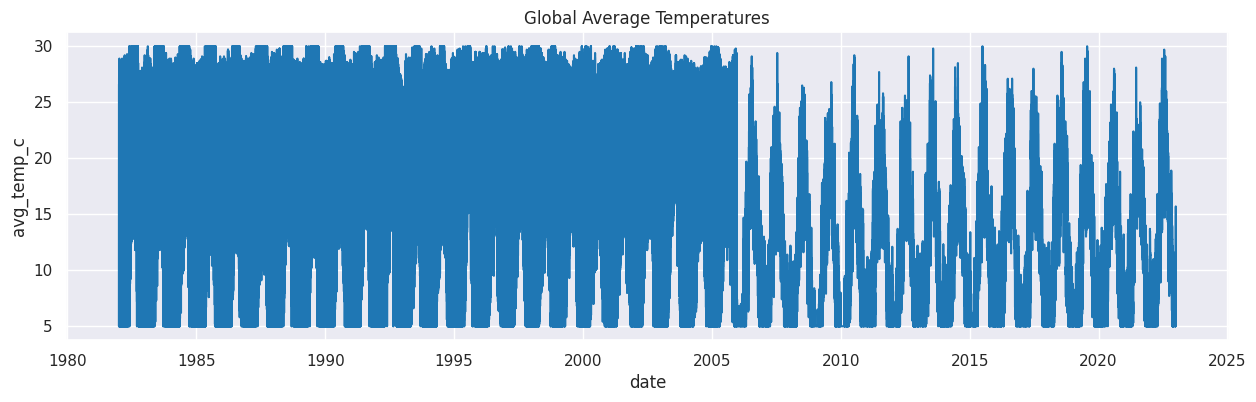

In [33]:
# cities_weather - all countries
plot_df(cities_weather, x=cities_weather['date'], y=cities_weather['avg_temp_c'], title='Global Average Temperatures', color='tab:blue')

#### ACF and PACF
Visualize the Autocorrelation and Partial Autocorrelation function

Autocorrelation - the measure of correlation between a given time series with its own previous values (lagged version of that time series over successive time periods). 

Partial Autocorrelation - the correlation of a series and its lag, excluding the correlation contributions from the intermediate lags.

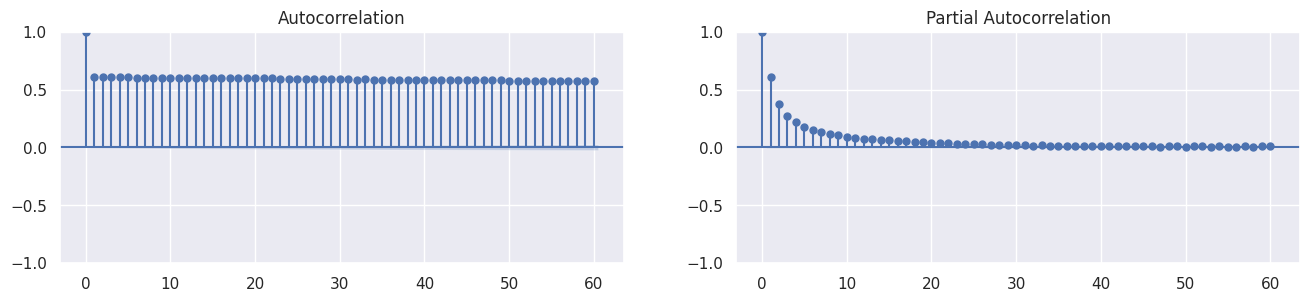

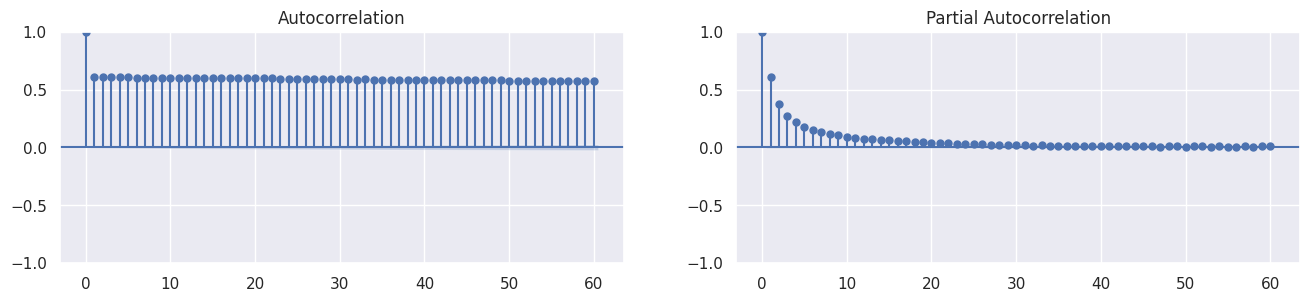

In [35]:
# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(cities_weather['avg_temp_c'].tolist(), lags=60, ax=axes[0])
plot_pacf(cities_weather['avg_temp_c'].tolist(), lags=60, ax=axes[1])

# Model Time Series

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

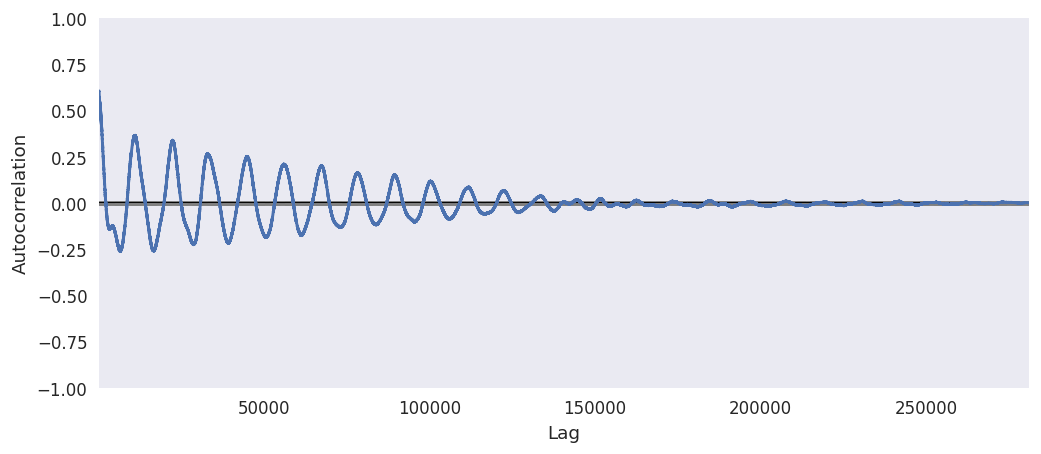

In [95]:
# Test for seasonality
# Draw Plot
plt.rcParams.update({'figure.figsize':(10,4), 'figure.dpi':120})
autocorrelation_plot(cities_weather['avg_temp_c'].tolist())

Check the dataset to see if it is stationary by using the Augmented Dickey-Fuller (ADF) or Kwiatkowski-Phillips-Schmidt-Shin (KPSS) statistical tests. 

### Augmented Dickey-Fuller (ADF) Test

ADF Test (most popular) - review the staionarity of the data

The ADF test assumptions:
- p-value >0.05 Fail to reject (H0 - non-stationary)
- p-value <= 0.05 Accept (H1 - stationary)


In [34]:
ADF_result = adfuller(cities_weather['avg_temp_c'])

print(f'ADF Statistic: {ADF_result[0]:.3f}')
print(f'p-value: {ADF_result[1]:.3f}')

ADF Statistic: -10.483
p-value: 0.000


##### With a large negative ADF Statistic and a p-value much smaller than 0.05, the series is stationary.

<blockquote>
If the ADF statistic was not a large negative number and the p-value was not smaller than 0.05, the series would not be stationary. Being non-stationary would require applied transformations on the series. To stabilize the trend a x-order differencing can be applied (noted below).

<code>cities_weather_diff = np.diff(cities_weather['avg_temp_c'], n=x)</code> 

To verify re-check test for stationarity using the ADF test
    
<code> ADF_result = adfuller(cities_weather_diff)</code>   
 
<code> print(f'ADF Statistic: {ADF_result[0]}')</code>
<code> print(f'p-value: {ADF_result[1]}')</code>

Once the order of the moving average is identified the process can be moved to fit the model to the training/test data and start forecasting.
</blockquote>


####  Non-machine learning baseline
Added the mean of the data as a baseline reference

In [98]:
mean_value = cities_weather['avg_temp_c'].mean()
print("\nNon ML Baseline")
print(f'\nMean: {mean_value}')


Non ML Baseline

Mean: 12.416625178694622


### Train - Test

In ML typically the sklearn train_test_split function is used, but for time series that will not work. 

The train_test_split function splits the data randomly and time series there is a dependence from one observation to the other.

For time series, you can use split the dataset into train-test or test-validation-test, using the firt part as train and last part (train-test split).

In [28]:
# Make a copy of the dataframe to encode categorical data
cities_weather_enc2 = cities_weather.copy()    

In [37]:
#Test - Train split for Simple Moving Average Model, MA, AR, ARMA, ARIMA, SARIMA

split_indx = int(0.9*len(cities_weather_enc2))  

train_data = cities_weather_enc2.iloc[0:split_indx]    # select the rows for training model.                            
test_data = cities_weather_enc2.iloc[split_indx:]      # rows to evaluate forecasting model performance  

### Encode data for modeling

#### Encode categorical variables for modeling with Label Encoder

Classic Encoder - sklearn.preprocessing.LabelEncoder() code

In [29]:
# Label_encoder object
label_encoder = LabelEncoder()

# Encode label in column. 
cities_weather_enc2['country']= label_encoder.fit_transform(cities_weather_enc2['country'])
# Encode label in column. 
cities_weather_enc2['season']= label_encoder.fit_transform(cities_weather_enc2['season'])

# display updated encoded dataframe - seasons, countries, cities
cities_weather_enc2.tail(3)

,date,season,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh,peak_wind_gust_kmh,avg_sea_level_pres_hpa,sunshine_total_min,country,latitude,longitude
281203,2022-12-31,3,9.9,7.2,12.4,6.3,0.0,222.0,38.2,68.0,1002.5,0.0,4,55.583337,13.033302
281204,2022-12-31,3,14.1,7.8,17.3,0.0,0.0,215.0,26.3,68.4,1005.9,43.0,2,52.400405,13.069993
281205,2022-12-31,3,11.4,6.1,16.0,0.0,0.0,268.0,6.8,37.1,1022.6,237.0,5,47.567997,9.108001


In [33]:
# calculating Min and Max DateTimes to review timeframe range
print(f"\n\ncities_weather_enc2 min date: {cities_weather_enc2['date'].min()}")
print(f"cities_weather_enc2 max date: {cities_weather_enc2['date'].max()}")



cities_weather_enc2 min date: 1982-01-01 00:00:00
cities_weather_enc2 max date: 2022-12-31 00:00:00


In [39]:
del cities_weather
gc.collect()

20

## Classical Time Series Forecasting Methods MA, AR, ARMA, ARIMA, SARIMA

### Autoregressive Method using AutoReg (AR)
Auto-Regressive (AR): The model captures the linear relationship between the current data point and its past values, making it ideal for understanding long-term trends.

In [53]:
# fit model for AR
ar_model = AutoReg(train_data['avg_temp_c'], lags=4)
ar_model_fit = ar_model.fit()

# make prediction                                      
pred_ar = ar_model_fit.predict(start=len(train_data), end=len(cities_weather_enc2)-1) 
print(pred_ar)

253085    22.281661
253086    21.504281
253087    20.899068
253088    19.716567
253089    19.815285
            ...    
281201    12.641853
281202    12.641853
281203    12.641853
281204    12.641853
281205    12.641853
Length: 28121, dtype: float64


In [54]:
ar_mae = mean_absolute_error(test_data['avg_temp_c'], pred_ar)
ar_mse = mean_squared_error(test_data['avg_temp_c'], pred_ar) 
ar_rmse = np.sqrt(ar_mse)
ar_mape = mean_absolute_percentage_error(test_data['avg_temp_c'], pred_ar)
print("AR Model Evaluation:")
#print(f'\n MAE: {ar_mae}\n RMSE: {ar_rmse}\n MSE: {ar_mse}')
print(f'\n MAE: {ar_mae}\n RMSE: {ar_rmse}\n MSE: {ar_mse} \n MAPE: {ar_mape}')

AR Model Evaluation:

 MAE: 5.389018328640135
 RMSE: 6.051925805528031
 MSE: 36.6258059556161 
 MAPE: 0.7531227747495365


### Moving Average Method using ARIMA (MA)
Moving Average: a model that smooths out variations in data by calculating the average of a rolling window of past observations.

In [55]:
# fit model for MA
ma_model = ARIMA(train_data['avg_temp_c'], order=(0, 0, 1))
ma_model_fit = ma_model.fit()

# make prediction                                      
pred_ma = ma_model_fit.predict(start=len(train_data), end=len(cities_weather_enc2)-1, typ="levels") 
print(pred_ma)

253085    13.640601
253086    12.640987
253087    12.640987
253088    12.640987
253089    12.640987
            ...    
281201    12.640987
281202    12.640987
281203    12.640987
281204    12.640987
281205    12.640987
Name: predicted_mean, Length: 28121, dtype: float64


In [57]:
ma_mae = mean_absolute_error(test_data['avg_temp_c'], pred_ma)
ma_mse = mean_squared_error(test_data['avg_temp_c'], pred_ma) 
ma_rmse = np.sqrt(ma_mse)
ma_mape = mean_absolute_percentage_error(test_data['avg_temp_c'], pred_ma)
print("MA Model Evaluation:")
print(f'\n MAE: {ma_mae}\n RMSE: {ma_rmse}\n MSE: {ma_mse} \n MAPE: {ma_mape}')

MA Model Evaluation:

 MAE: 5.393861715736532
 RMSE: 6.0595186375172725
 MSE: 36.717766118419185 
 MAPE: 0.7532662021092134


### Autoregressive Moving Average (ARMA)

Autoregressive Moving Average (ARMA): Combining the AR and Moving Average models, ARMA can model both short-term fluctuations and long-term trends.

In [58]:
# fit model for ARMA
arma_model = ARIMA(train_data['avg_temp_c'], order=(2, 0, 1))
arma_model_fit = arma_model.fit()

# make prediction                                                 
pred_arma = arma_model_fit.predict(start=len(train_data), end=len(cities_weather_enc2)-1) 
print(pred_arma)

253085    22.681326
253086    22.654040
253087    22.652951
253088    22.651661
253089    22.650372
            ...    
281201    12.909537
281202    12.909502
281203    12.909468
281204    12.909433
281205    12.909399
Name: predicted_mean, Length: 28121, dtype: float64


In [59]:
arma_mae = mean_absolute_error(test_data['avg_temp_c'], pred_arma)
arma_mse = mean_squared_error(test_data['avg_temp_c'], pred_arma) 
arma_rmse = np.sqrt(arma_mse)
arma_mape = mean_absolute_percentage_error(test_data['avg_temp_c'], pred_arma)
print("ARMA Model Evaluation:")
print(f'\n MAE: {arma_mae}\n RMSE: {arma_rmse}\n MSE: {arma_mse} \n MAPE: {arma_mape}')

ARMA Model Evaluation:

 MAE: 6.795034414815716
 RMSE: 7.838522572091088
 MSE: 61.44243611318148 
 MAPE: 1.0150905911317876


### Autoregressive Integrated Moving Average (ARIMA)

Autoregressive Integrated Moving Average (ARIMA): ARIMA takes into account differencing to make the time series stationary, making it versatile for various data patterns.

In [40]:
# fit model for ARIMA
arima_model = ARIMA(train_data['avg_temp_c'], order=(1, 1, 1))
arima_model_fit = arima_model.fit()

# make prediction                                                     
pred_arima = arima_model_fit.predict(start=len(train_data), end=len(cities_weather_enc2)-1, typ='levels') 
print(pred_arima)

253085    22.710385
253086    22.683820
253087    22.684027
253088    22.684025
253089    22.684025
            ...    
281201    22.684025
281202    22.684025
281203    22.684025
281204    22.684025
281205    22.684025
Name: predicted_mean, Length: 28121, dtype: float64


In [42]:
test_data['arima_predict'] = pred_arima

<Axes: xlabel='date'>

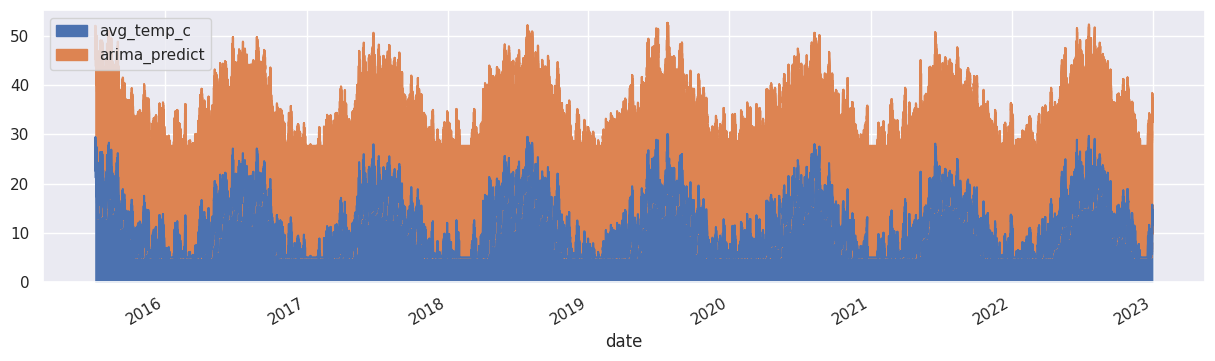

In [44]:
# form dataframe from data
df = pd.DataFrame(test_data, columns=["avg_temp_c", "arima_predict", "date"])

# plot multiple columns such as population and year from dataframe
df.plot(x="date", y=["avg_temp_c", "arima_predict"], kind="area", figsize=(15, 4))

In [60]:
arima_mae = mean_absolute_error(test_data['avg_temp_c'], pred_arima)
arima_mse = mean_squared_error(test_data['avg_temp_c'], pred_arima) 
arima_rmse = np.sqrt(arima_mse)
arima_mape = mean_absolute_percentage_error(test_data['avg_temp_c'], pred_arima)
print("ARIMA Model Evaluation:")
print(f'\n MAE: {arima_mae}\n RMSE: {arima_rmse}\n MSE: {arima_mse} \n MAPE: {arima_mape}')

ARIMA Model Evaluation:

 MAE: 12.394038944746567
 RMSE: 13.514604513676298
 MSE: 182.64453516107977 
 MAPE: 1.857064182078994


### Seasonal Autoregressive Integrated Moving-Average (SARIMA)
Seasonal Autoregressive Integrated Moving-Average (SARIMA): SARIMA extends ARIMA by considering seasonal components, crucial for weather data with recurring patterns.

In [61]:
# fit model for SARIMA                                              
sarima_model = SARIMAX(train_data['avg_temp_c'], order=(2, 0, 2), seasonal_order=(1, 1, 2, 4)) 
sarima_model_fit = sarima_model.fit(disp=False)

# make prediction                                                    
pred_sarima = sarima_model_fit.predict(start=len(train_data), end=len(cities_weather_enc2)-1, typ='levels') 
print(pred_sarima)  

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


253085    22.526080
253086    22.497993
253087    22.474834
253088    22.510794
253089    22.487779
            ...    
281201    12.294400
281202    12.282073
281203    12.271452
281204    12.313229
281205    12.294400
Name: predicted_mean, Length: 28121, dtype: float64


In [47]:
test_data['sarima_predict'] = pred_sarima

<Axes: xlabel='date'>

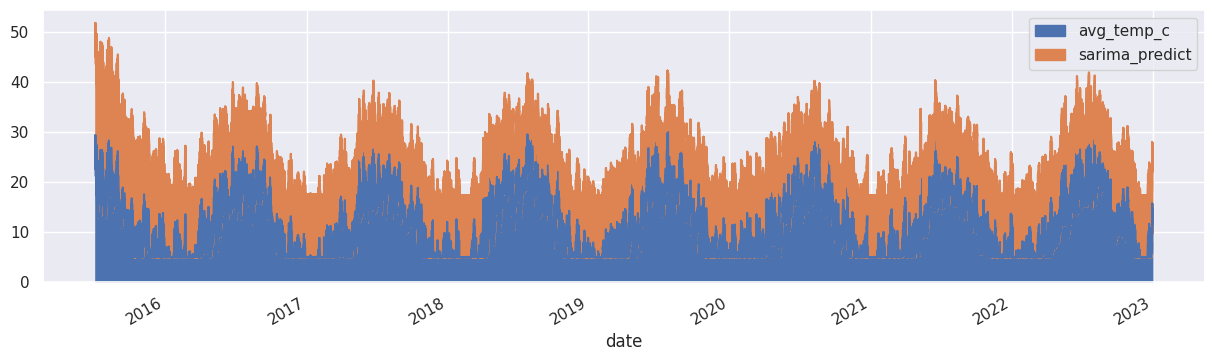

In [48]:
# form dataframe from data
df = pd.DataFrame(test_data, columns=["avg_temp_c", "sarima_predict", "date"])

# plot multiple columns such as population and year from dataframe
df.plot(x="date", y=["avg_temp_c", "sarima_predict"], kind="area", figsize=(15, 4))

In [62]:
sarima_mae = mean_absolute_error(test_data['avg_temp_c'], pred_sarima)
sarima_mse = mean_squared_error(test_data['avg_temp_c'], pred_sarima)
sarima_rmse = np.sqrt(sarima_mse)
sarima_mape = mean_absolute_percentage_error(test_data['avg_temp_c'], pred_sarima)
print("SARIMA Model Evaluation:")
print(f'\n MAE: {sarima_mae}\n RMSE: {sarima_rmse}\n MSE: {sarima_mse} \n MAPE: {sarima_mape}')

SARIMA Model Evaluation:

 MAE: 5.46788186161846
 RMSE: 6.136993535492452
 MSE: 37.66268965467614 
 MAPE: 0.759823596578506


In [50]:
sarima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                        avg_temp_c   No. Observations:               253085
Model:             SARIMAX(2, 0, 2)x(1, 1, 2, 4)   Log Likelihood             -761855.735
Date:                           Mon, 30 Oct 2023   AIC                        1523727.470
Time:                                   15:03:11   BIC                        1523811.001
Sample:                                        0   HQIC                       1523751.806
                                        - 253085                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0867      1.646      0.053      0.958      -3.138       3.312
ar.L2          0.9119      1.644      0.555      0.579      -2.311       4.135
ma.L1         -0.0431      1.646     -0.026      0.979      -3.269       3.182
ma.L2         -0.8721      1.573     -0.554      0.579      -3.955       2.211
ar.S.L4       -0.9855      0.018    -54.888      0.000      -1.021      -0.950
ma.S.L4       -0.0140      0.018     -0.790      0.430      -0.049       0.021
ma.S.L8       -0.9860      0.018    -55.800      0.000      -1.021      -0.951
sigma2        24.1025      0.047    508.791      0.000      24.010      24.195
===================================================================================
Ljung-Box (L1) (Q):                  13.74   Jarque-Bera (JB):            470453.52
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.53   Skew:                             1.95
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

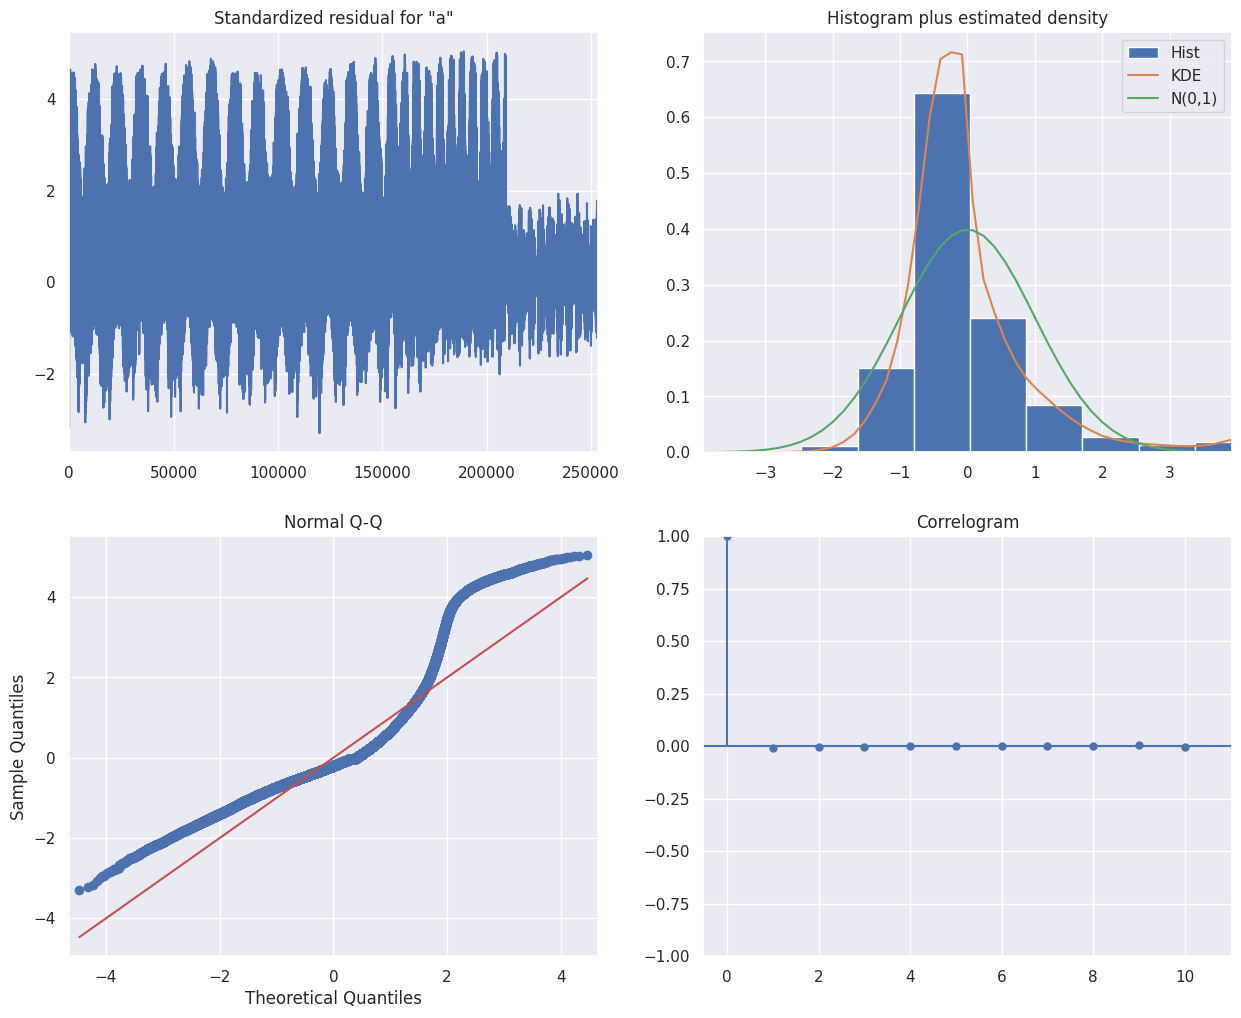

In [51]:
# study the residuals:
sarima_model_fit.plot_diagnostics(figsize=(15,12))
plt.show()

In [63]:
# drop arima and sarima predictions from original test_data dataframe - copy to a separate dataframe with all model predictions

test_data.drop(["arima_predict", "sarima_predict"], axis=1, inplace=True)

test_data.columns

Index(['date', 'season', 'avg_temp_c', 'min_temp_c', 'max_temp_c',
       'precipitation_mm', 'snow_depth_mm', 'avg_wind_dir_deg',
       'avg_wind_speed_kmh', 'peak_wind_gust_kmh', 'avg_sea_level_pres_hpa',
       'sunshine_total_min', 'country', 'latitude', 'longitude'],
      dtype='object')

In [64]:
gc.collect()

14557

### LSTM Forecast

source:  https://github.com/marcopeix/TimeSeriesForecastingInPython/blob/master/CH18/CH18_modeling.ipynb

LSTM (Long Short-Term Memory): Leveraging the power of deep learning, LSTM captures complex temporal dependencies, enabling precise forecasting in dynamic weather scenarios.

In [56]:
# Make a copy of the dataframe to set date column as the index
cities_weather_lstm = cities_weather_enc2.copy()

# set date as the index
cities_weather_lstm = cities_weather_lstm.set_index("date")

In [57]:
# train-test source

n = len(cities_weather_lstm)
train_lstm = cities_weather_lstm[0:int(n*0.7)]
val_lstm = cities_weather_lstm[int(n*0.7):int(n*0.9)]
test_lstm = cities_weather_lstm[int(n*0.9):]

num_features = cities_weather_lstm.shape[1]

In [58]:
# DataWindow class

class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_lstm, val_df=val_lstm, test_df=test_lstm, 
                 label_columns=None):
        
        self.train_df = train_lstm
        self.val_df = val_lstm
        self.test_df = test_lstm
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_lstm.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='avg_temp_c', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='orange', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [59]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [60]:
column_indices = {name: i for i, name in enumerate(train_lstm.columns)}

In [61]:
# Baseline models
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['avg_temp_c'])

In [62]:
val_performance = {}
performance = {}

In [72]:
lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(lstm_model, multi_window)

val_performance['LSTM'] = lstm_model.evaluate(multi_window.val)
performance['LSTM'] = lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
6150/6150 [==============================] - 88s 14ms/step - loss: 48.5550 - mean_absolute_error: 5.1052 - val_loss: 13.1902 - val_mean_absolute_error: 2.6806
Epoch 2/50
6150/6150 [==============================] - 86s 14ms/step - loss: 30.7318 - mean_absolute_error: 4.0107 - val_loss: 12.7461 - val_mean_absolute_error: 2.6309
Epoch 3/50
6150/6150 [==============================] - 85s 14ms/step - loss: 30.4703 - mean_absolute_error: 3.9850 - val_loss: 12.6890 - val_mean_absolute_error: 2.6387
Epoch 4/50
6150/6150 [==============================] - 86s 14ms/step - loss: 30.4821 - mean_absolute_error: 3.9898 - val_loss: 13.8947 - val_mean_absolute_error: 2.8036
Epoch 5/50
6150/6150 [==============================] - 85s 14ms/step - loss: 30.3534 - mean_absolute_error: 3.9736 - val_loss: 13.0447 - val_mean_absolute_error: 2.6876
Epoch 6/50
1757/1757 [==============================] - 9s 5ms/step - loss: 13.1915 - mean_absolute_error: 2.7145


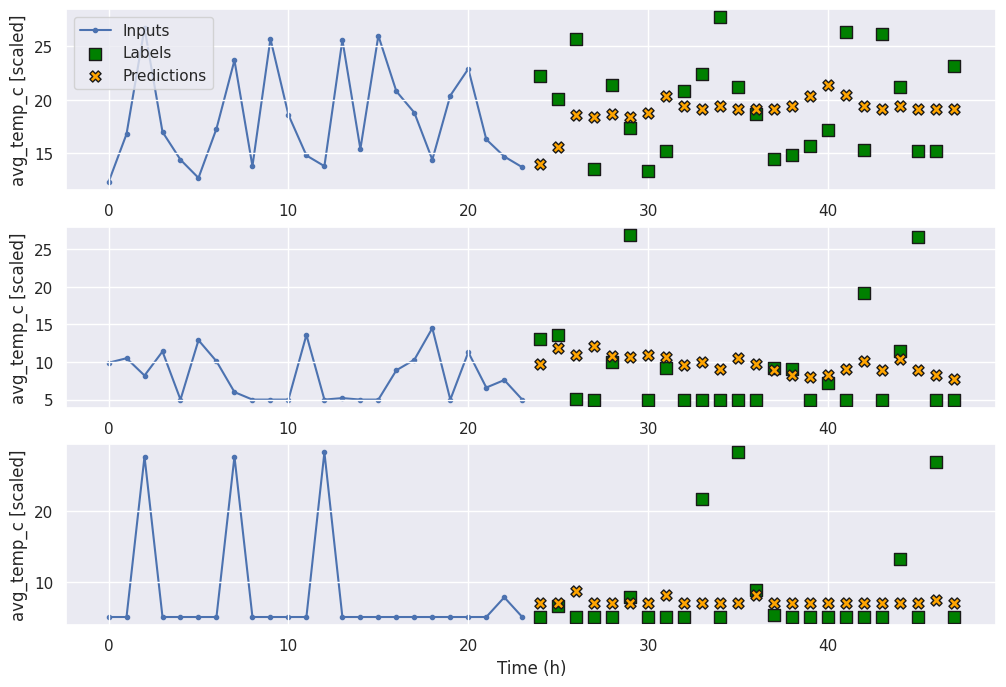

In [73]:
multi_window.plot(lstm_model)

In [74]:
print(val_performance) # validation split loss and MAE
print(performance) # test split loss (MSE) and MAE 

{'LSTM': [13.191455841064453, 2.714547634124756]}
{'LSTM': [9.674196243286133, 2.57930850982666]}


In [63]:
mse_test = [v[0] for v in performance.values()]
mae_test = [v[1] for v in performance.values()]

lstm_mae = mae_test.pop()
lstm_mse = mse_test.pop()
lstm_rmse = np.sqrt(lstm_mse)

print("LSTM Model Evaluation:")
print(f"lstm_mae: {lstm_mae}")
print(f"lstm_rmse: {lstm_rmse}")
print(f"lstm_mse: {lstm_mse}")

### Prophet Forecast
sources: 
https://github.com/dipanjanS/practical-machine-learning-with-python/blob/master/notebooks/Ch11_Forecasting_Stock_and_Commodity_Prices/notebook_stock_prediction_fbprophet.ipynb
https://colab.research.google.com/drive/1Zz--8n9HsxHpNUm1GNFm2G4db3r7pKqR#scrollTo=0dd91ffd

Prophet: Developed by Facebook, excellent at handling data with recurring patterns, detects changepoints in the data, and handles missing data and outliers gracefully.

In [30]:
cities_weather_pr = cities_weather_enc2[["date", "avg_temp_c"]]

In [37]:
cities_weather_pr.columns = ['ds', 'y']

In [38]:
cities_weather_pr.head(3)

,ds,y
0,1982-01-01,26.6
1,1982-01-01,5.0
2,1982-01-01,6.8


In [39]:
# prepare train and test sets
train_size_pr = int(cities_weather_pr.shape[0]*0.9)
train_pr = cities_weather_pr.iloc[:train_size_pr]
test_pr = cities_weather_pr.iloc[train_size_pr+1:]

In [40]:
# build a prophet model
m = Prophet()
m.fit(train_pr)

18:02:29 - cmdstanpy - INFO - Chain [1] start processing
18:04:31 - cmdstanpy - INFO - Chain [1] done processing


In [41]:
# prepare a future dataframe
pr_test_dates = m.make_future_dataframe(4, freq='Y')

# forecast values
forecast = m.predict(pr_test_dates)

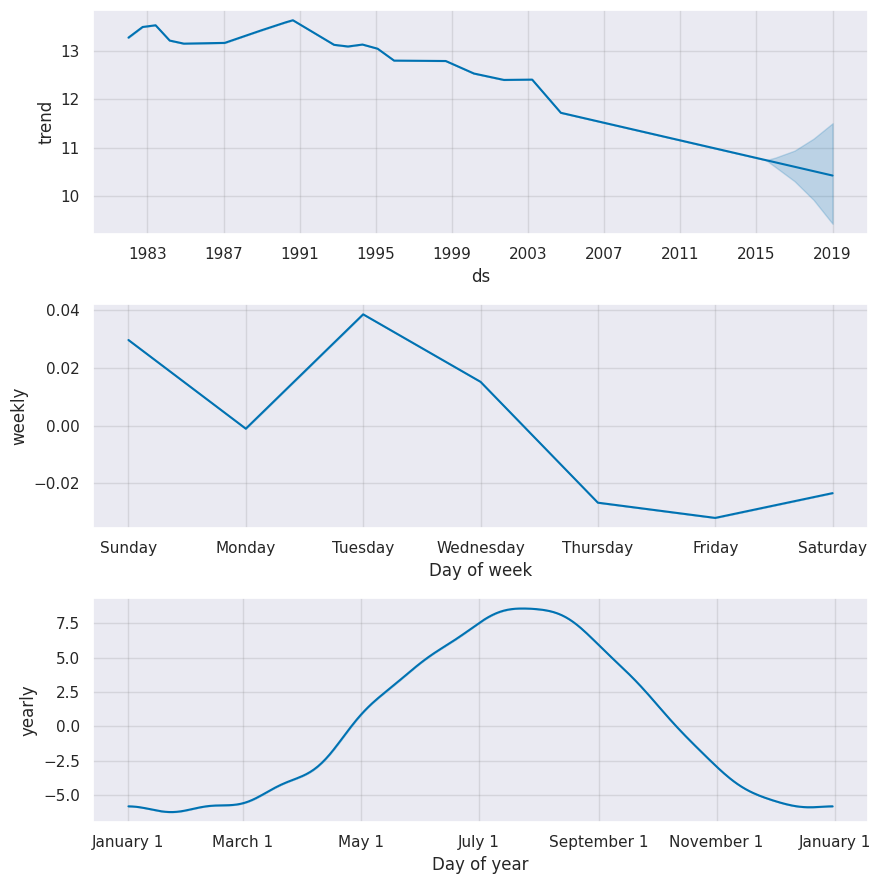

In [82]:
components_plot = m.plot_components(forecast)

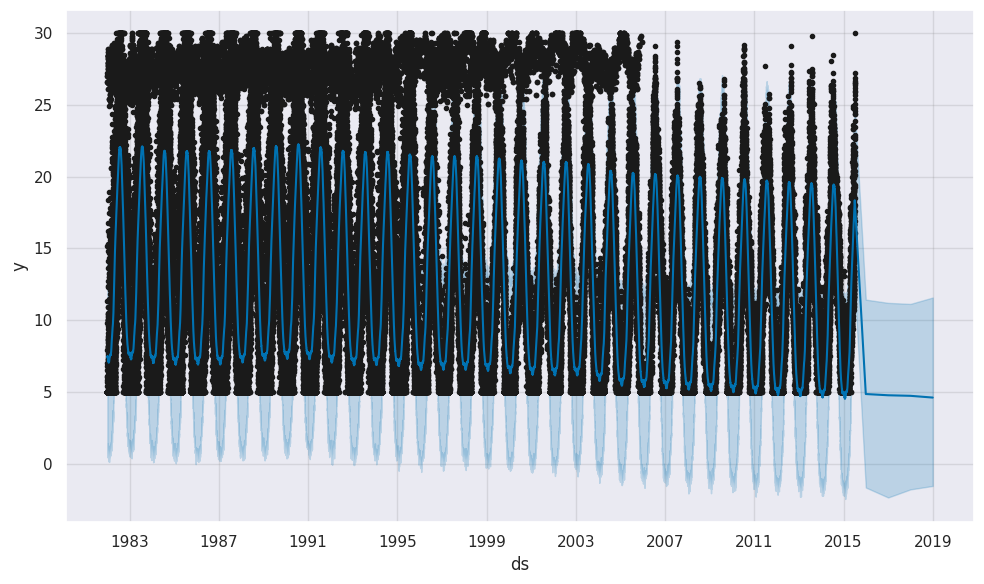

In [42]:
forecast_plot = m.plot(forecast)

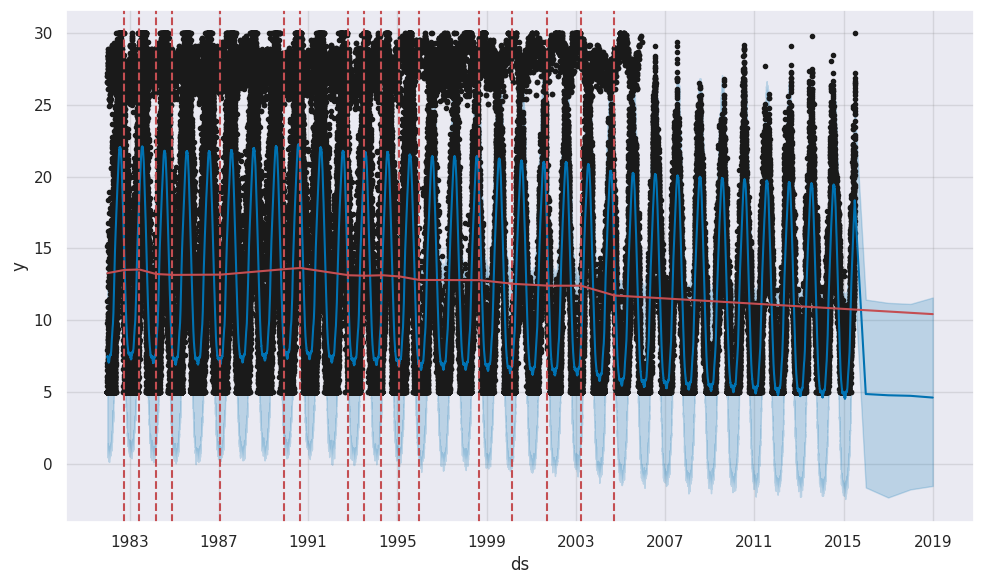

In [43]:
chgpoints_plot = m.plot(forecast)
a = add_changepoints_to_plot(chgpoints_plot.gca(), m, forecast)

In [46]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
12223,2015-07-03,18.799332,12.328249,24.874866
12224,2015-12-31,5.459728,-0.513348,11.642386
12225,2016-12-31,5.513670,-0.722281,11.899909
12226,2017-12-31,5.641092,-0.843684,12.219815
12227,2018-12-31,5.674220,-0.747050,12.021057


In [49]:
pr_df_merge = pd.merge(cities_weather_pr, forecast[['ds','yhat_lower','yhat_upper','yhat']],on='ds')
pr_df_merge = pr_df_merge[['ds','yhat_lower','yhat_upper','yhat','y']]
pr_df_merge.head()

,ds,yhat_lower,yhat_upper,yhat,y
0,1982-01-01,0.733008,13.707872,7.068912,26.6
1,1982-01-01,0.733008,13.707872,7.068912,5.0
2,1982-01-01,0.733008,13.707872,7.068912,6.8
3,1982-01-01,0.733008,13.707872,7.068912,5.0
4,1982-01-01,0.733008,13.707872,7.068912,5.0


In [52]:
# calculate MAE between observed and predicted values 
y_true = pr_df_merge['y'].values
y_pred = pr_df_merge['yhat'].values
pr_mae = mean_absolute_error(y_true, y_pred)
pr_mse = mean_squared_error(y_true, y_pred) 
pr_rmse = np.sqrt(pr_mse)
pr_mape = mean_absolute_percentage_error(y_true, y_pred)

print("Prophet Model Evaluation:")
print(f"pr_mae: {pr_mae}")
print(f"pr_rmse: {pr_rmse}")
print(f"pr_mse: {pr_mse}")
print(f"pr_mape: {pr_mape}")

pr_mae: 3.605518260793805
pr_rmse: 5.093120210812139
pr_mse: 25.939873481783085


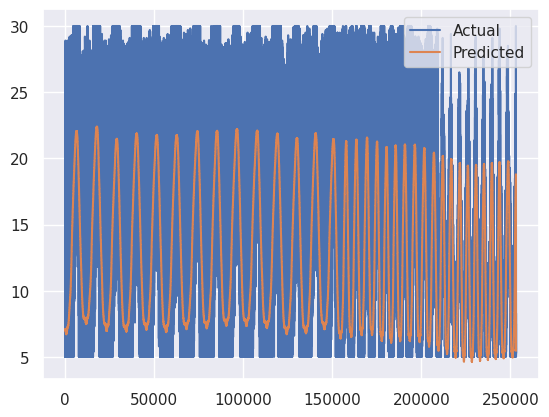

In [54]:
# plot expected vs actual
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [114]:
fe_results_plus_lstm_pr = pd.DataFrame({'Model':['Prophet','LSTM','SARIMA', 'ARIMA', 'ARMA', 'MA', 'AR'], \
                           'MAE': [pr_mae, lstm_mae, sarima_mae, arima_mae, arma_mae, ma_mae, ar_mae],\
                           'RMSE': [pr_rmse, lstm_rmse, sarima_rmse, arima_rmse, arma_rmse, ma_rmse, ar_rmse], \
                           'MSE': [pr_mse, lstm_mse, sarima_mse, arima_mse, arma_mse, ma_mse, ar_mse]})

print(fe_results_plus_lstm_pr)

# Export dataframe to csv for Dash App
fe_results_plus_lstm_pr.to_csv('forecasting.csv')

    Model        MAE       RMSE         MSE
0    LSTM   2.913779   3.521789   12.402999
1  SARIMA   5.467882   6.136994   37.662690
2   ARIMA  12.394039  13.514605  182.644535
3    ARMA   6.795034   7.838523   61.442436
4      MA   5.393862   6.059519   36.717766
5      AR   5.389018   6.051926   36.625806


### Moving Forward

This was my first Time Series modeling project - I look forward to making improvements as I learn more :)

#### Reference sources

https://www.kaggle.com/code/prashant111/complete-guide-on-time-series-analysis-in-python

https://otexts.com/fpp3/tspatterns.html

https://www.oreilly.com/library/view/time-series-forecasting/9781617299889/ 

https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-to-time-series-analysis/

https://www.kaggle.com/code/discdiver/category-encoders-examples/notebook

https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/

https://github.com/marcopeix/TimeSeriesForecastingInPython/blob/master/CH18/CH18_modeling.ipynb

https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb#scrollTo=ia-MPAHxbInX

https://github.com/dipanjanS/practical-machine-learning-with-python/blob/master/notebooks/Ch11_Forecasting_Stock_and_Commodity_Prices/notebook_stock_prediction_fbprophet.ipynb

https://colab.research.google.com/drive/1Zz--8n9HsxHpNUm1GNFm2G4db3r7pKqR#scrollTo=0dd91ffd

https://hub.packtpub.com/what-is-lstm/

https://www.analyticsvidhya.com/blog/2021/03/introduction-to-long-short-term-memory-lstm/

https://medium.com/@theAIPlusBlog/time-series-analysis-9ac99c1f277